In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 20000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()

# cap = cv2.VideoCapture('video_drone_tank.avi')


# ret, frame = cap.read()

# uframes.append(frame)
# flag = 0
# z = 0
# while(z<30):
#     ret, frame = cap.read()
#     #np_frame = cv2.imread('video', frame) # does not work
#     #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
#     #print(np_frame.shape)
#     for a in uframes:
#         if (np.array(a).any() != None):
#             print("a: ",np.shape(a))
#             print("frame: ",np.shape(a))
#             difference = cv2.subtract(np.array(a), np.array(frame))    
#             result = not np.any(difference)
#             #print("inside for")
#             if result is True:
#                 flag = 1
#                 #print("setting flag")
#                 break
#     if(not flag):
#         #print("appending")
#         uframes.append(frame)
#     z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)
    


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2s
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(5184, 15)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    #print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


(100, 100, 3)
length:  2642
(20000, 3, 100, 100)
epoch [1/200], loss:-4.7737
epoch [2/200], loss:-5.1112
epoch [3/200], loss:-5.3563
epoch [4/200], loss:-5.6149
epoch [5/200], loss:-5.4948
epoch [6/200], loss:-5.7055
epoch [7/200], loss:-5.8442
epoch [8/200], loss:-5.7105
epoch [9/200], loss:-5.7777
epoch [10/200], loss:-5.6870
epoch [11/200], loss:-5.6105
epoch [12/200], loss:-5.7324
epoch [13/200], loss:-5.6452
epoch [14/200], loss:-5.6797
epoch [15/200], loss:-5.7230
epoch [16/200], loss:-5.5868
epoch [17/200], loss:-5.8679
epoch [18/200], loss:-5.5311
epoch [19/200], loss:-5.5591
epoch [20/200], loss:-5.8867
epoch [21/200], loss:-5.8222
epoch [22/200], loss:-5.6026
epoch [23/200], loss:-5.3520
epoch [24/200], loss:-5.6828
epoch [25/200], loss:-5.7414
epoch [26/200], loss:-5.6853
epoch [27/200], loss:-5.8683
epoch [28/200], loss:-5.7225
epoch [29/200], loss:-5.6659
epoch [30/200], loss:-5.7922
epoch [31/200], loss:-5.4982
epoch [32/200], loss:-5.6953
epoch [33/200], loss:-5.7897
epo

In [8]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_moving_panels={}
tank_reloading_panels={}
tmtr_panels={}

uframes = []
vidcap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()
for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))

num_channels = 16
buffer = 5

tmtr = 38
tm = 4
tr = 46

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

def image_to_numpy(img):
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    return output


for i in range(num_channels):

    
    output = image_to_numpy(uframes[tmtr])
    tmtr_panel = output[0][i]
    val_tmtr,pos_tmtr = val_pos(tmtr_panel)
    print("Tank Moving Tank Reloading Panel: ",val_tmtr,pos_tmtr)
    print("**********")
    
    output = image_to_numpy(uframes[tm])
    tm_panel = output[0][i]
    val_tm,pos_tm = val_pos(tm_panel)
    print("Tank Moving Panel: ",val_tm,pos_tm)
    print("**********")
    
    
    output = image_to_numpy(uframes[tr])
    tr_panel = output[0][i]
    val_tr,pos_tr = val_pos(tr_panel)
    print("Tank Reloading Panel: ",val_tr,pos_tr)
    print("**********")
    
       
    print("\nPanel ",i)
    print("\n++++++++++++++++++++++++++++++++++++++++++++\n")
    
    if val_tm > max(val_tmtr,val_tr):
        tank_moving_panels[i] = val_tm - buffer
    elif val_tr > max(val_tmtr,val_tm):
        tank_reloading_panels[i] = val_tr - buffer
    elif val_tmtr > max(val_tr,val_tm):
        tmtr_panels[i] = val_tmtr - buffer
        

print("\nTank Moving: \n", tank_moving_panels)
print("\nTank Reloading: \n", tank_reloading_panels)
print("\nTank Moving and Reloading\n",tmtr_panels)


Tank Moving Tank Reloading Panel:  2710.6716 (5, 3)
**********
Tank Moving Panel:  2944.8523 (5, 1)
**********
Tank Reloading Panel:  2245.1267 (4, 3)
**********

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  3262.2388 (6, 2)
**********
Tank Moving Panel:  3656.2668 (6, 0)
**********
Tank Reloading Panel:  2868.5469 (4, 3)
**********

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  3559.4119 (5, 4)
**********
Tank Moving Panel:  3923.517 (5, 2)
**********
Tank Reloading Panel:  2808.9937 (6, 13)
**********

Panel  2

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  1915.5817 (4, 1)
**********
Tank Moving Panel:  1846.6992 (7, 0)
**********
Tank Reloading Panel:  2047.2137 (5, 2)
**********

Panel  3

++++++++++++++++++++++++++++++++++++++++++++

Tank Moving Tank Reloading Panel:  2439.2695 (5, 2)
**********
Tank Moving Panel:  2540.7788 (5, 0)
**********
Tank Reloadin

In [5]:
import cv2


cap = cv2.VideoCapture('C:\\Users\\darshan19\\Downloads\\atari\\atari_2_vehicles.avi')

fps = int(cap.get(1))

frame_width = int(cap.get(3))

frame_height = int(cap.get(4))

print(frame_width,frame_height)
tankrc=[]


tank_moving_panels = {0: 2939.852294921875, 1: 3651.266845703125, 2: 3918.51708984375, 
                      4: 2535.77880859375, 6: 2757.001953125, 8: 1897.1790771484375, 
                      12: 2739.127685546875, 15: 2944.8779296875}

tank_reloading_panels = {3: 2042.2137451171875, 5: 2765.12841796875, 
                         7: 3176.161376953125, 10: 2638.602783203125, 11: 3490.5673828125, 14: 1660.1922607421875}

tmtr_panels = {9: 2719.021484375, 13: 3320.355712890625}

keys = list(tank_reloading_panels.keys())
keys_tmtr  = list(tmtr_panels.keys())
keys_tm = list(tank_moving_panels.keys())

uframes=[]
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.

out = cv2.VideoWriter('Two Aliens.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10,(frame_width,frame_height))

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
ret, frame = cap.read()

while(ret):
    #Capture frames in the video
    #describe the type of font
    #to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
    #Use putText() method for
    #inserting text on video
    #print(np.shape(frame))
    uframes=[]
    uframes.append(cv2.resize(frame,(100,100)))
    img = uframes[0]
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()

    for key in keys:
        output_tankr = output[0][key]
        val_tankr,pos_tankr = val_pos(output_tankr)
        if val_tankr>tank_reloading_panels[key]:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            #l.append(i)
            # Display the resulting frame
            cv2.putText(frame, 'Fire Here',(73*pos_tankr[1],98*pos_tankr[0]), font, 2,(0,165, 255),5,cv2.LINE_4)
            cv2.putText(frame, 'Take Action: The Vehicle is going to fire', (50, 50), font, 2,(0,0, 255),5,cv2.LINE_4)

    for key in keys_tmtr:
        output_tankr = output[0][key]
        val_tankr,pos_tankr = val_pos(output_tankr)
        if  val_tankr>tmtr_panels[key]:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            #l.append(i)
            # Display the resulting frame
            cv2.putText(frame, 'Fire Here',(73*pos_tankr[1],98*pos_tankr[0]), font, 2,(0,165, 255),5,cv2.LINE_4)
            cv2.putText(frame, 'Take Action: The Vehicle is going to fire', (50, 50), font, 2,(0,0, 255),5,cv2.LINE_4)

    for key in keys_tm:
        output_tankr = output[0][key]
        val_tankr,pos_tankr = val_pos(output_tankr)
        if  val_tankr>tank_moving_panels[key]:
            #print("tank reloading present")
            tankm.append(pos_tankr)
            #l.append(i)
            # Display the resulting frame


    out.write(frame)
    ret, frame = cap.read()

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()

1770 1328


NameError: name 'np' is not defined

In [4]:
import time
for i in range(250,350):
    img = uframes[i]
    z = Image.fromarray(img)
    z.show()
    print(i)
    time.sleep(1)

250
251
252
253
254
255
256
257
258
259


KeyboardInterrupt: 

In [25]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

frames_considered = 130

temp = tank_reloading_panels

for j in range(len(list(temp))):
    l = []
    tank_info_panel = list(tank_moving_panels)[0]
    tankr_info_panel = list(tank_reloading_panels)[j]

    tank_threshold= tank_moving_panels[tank_info_panel]
    tankr_threshold= tank_reloading_panels[tankr_info_panel]
    
    def val_pos(array):
        value = np.sum(array)
        position = np.unravel_index(np.argmax(array),array.shape)
        return value,position
 
    tankc=[]
    tankrc=[]

    for i in range(frames_considered):
        img = uframes[i]
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        output_tankr = output[0][tankr_info_panel]

        val_tank,pos_tank = val_pos(output_tank)
        val_tankr,pos_tankr = val_pos(output_tankr)



        if val_tank>tank_threshold:
            #print("tank present")
            tankc.append(pos_tank)
            #l.append(i)
            
        if val_tankr>tankr_threshold:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            l.append(i)
            
        
    print("\n")
    print(list(temp)[j])
    print(l)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n")





0
[1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 74, 78, 79, 80, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 68, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
++++++++

[(9, 16), (9, 16), (9, 16), (9, 16), (9, 16), (9, 16), (9, 16), (9, 16), (9, 16), (9, 15), (9, 15), (9, 15), (9, 16), (9, 16), (9, 16), (9, 16), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 15), (9, 14), (9, 14), (9, 14), (9, 14), (9, 15), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 14), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 13), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 12), (9, 11), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 2), (6, 1), (6, 2), (6, 1), (6, 2), (6, 2), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (

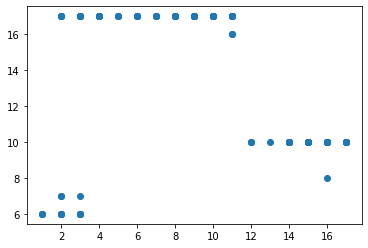

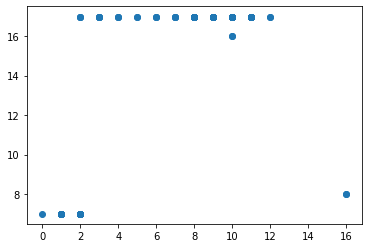

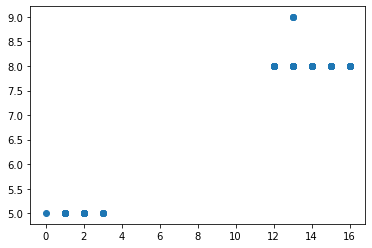

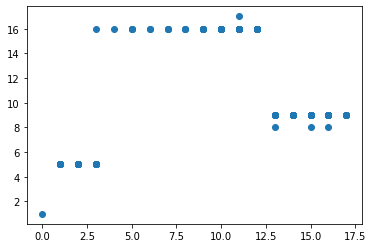

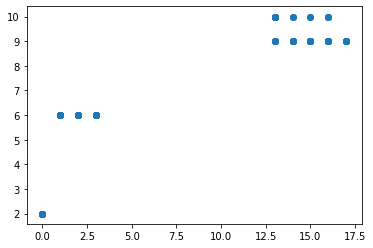

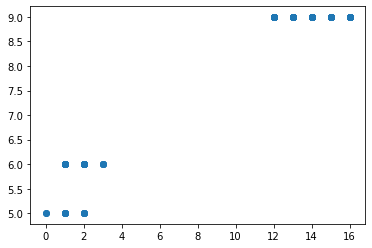

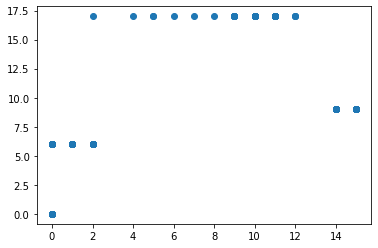

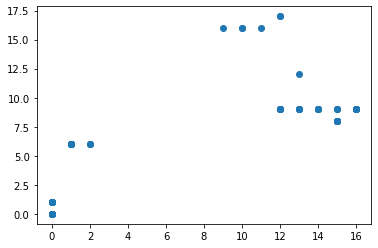

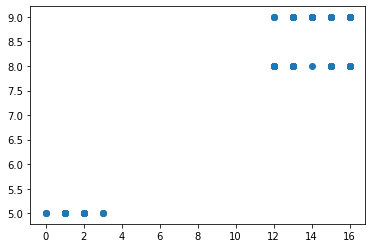

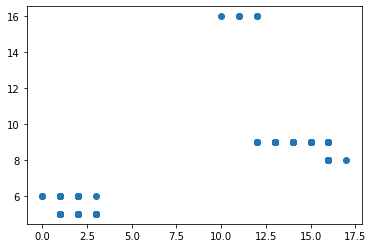

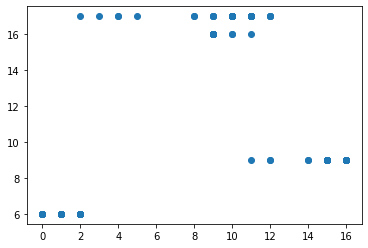

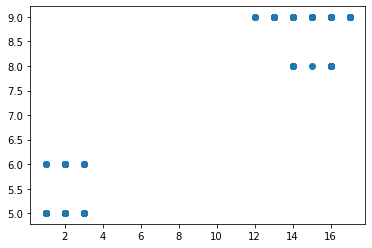

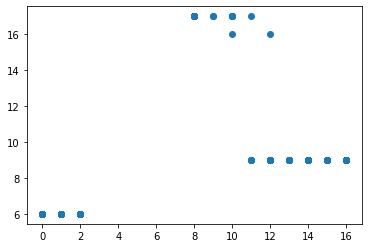

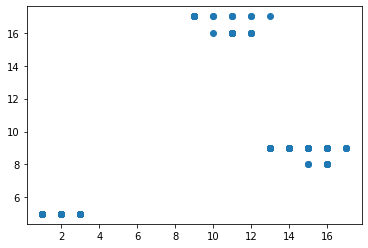

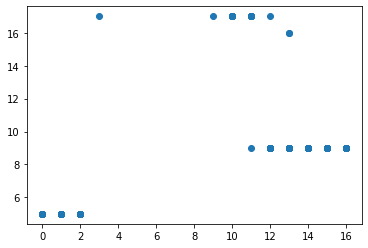

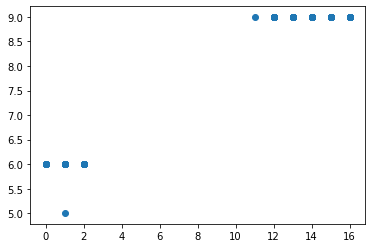

In [17]:
import sys
import matplotlib.pyplot as plt
print(tankc)

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

frames_considered = 130
#plt, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(16,16))

for j in range(16):
    l = []
    tank_info_panel = j
    tankc=[]
    for i in range(frames_considered):
        img = uframes[i]
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        val_tank,pos_tank = val_pos(output_tank)
        tankc.append(pos_tank)
    plt.figure()   
    x1 = [tankc[i][0] for i in range(len(tankc))]
    y1 = [tankc[i][1] for i in range(len(tankc))]
    plt.scatter(y1,x1)


In [64]:
img = uframes[24]
z = Image.fromarray(img)
z.show()

[(17, 8), (17, 8), (17, 8), (8, 16), (8, 16), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 8), (17, 9), (17, 9), (17, 9), (17, 9), (16, 10), (17, 9), (17, 10), (17, 10), (17, 10), (17, 10), (17, 10), (17, 10), (17, 11), (17, 11), (17, 11), (17, 11), (17, 11), (17, 11), (17, 12), (17, 12), (17, 11), (17, 11), (17, 11), (17, 11), (17, 11), (17, 11), (17, 10), (17, 10), (17, 10), (17, 10), (17, 10), (17, 10), (17, 9), (16, 10), (17, 9), (17, 9), (7, 2), (17, 9), (17, 8), (7, 2), (7, 2), (17, 8), (17, 8), (7, 2), (7, 2), (17, 7), (17, 7), (7, 2), (7, 2), (17, 7), (17, 7), (7, 2), (7, 2), (7, 2), (17, 6), (17, 6), (17, 6), (7, 2), (7, 1), (7

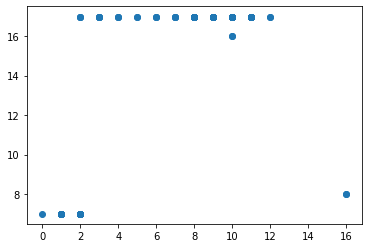

In [11]:
import numpy as np
import matplotlib.pyplot as plt
print(tankc)
x1 = [tankc[i][0] for i in range(len(tankc))]
y1 = [tankc[i][1] for i in range(len(tankc))]

# x2 = [tankrc[i][0] for i in range(len(tankrc))]
# y2 = [tankrc[i][1] for i in range(len(tankrc))]

# x3 = [tankfc[i][0] for i in range(len(tankfc))]
# y3 = [tankfc[i][1] for i in range(len(tankfc))]



# plt.scatter(y3,x3,color='black')
# plt.scatter(y2,x2,color='red')
plt.scatter(y1,x1)
# plt.show

[(13, 3), (13, 5), (13, 6), (13, 8), (13, 9), (13, 11), (10, 11), (10, 10), (10, 9), (10, 7), (10, 6), (10, 5), (10, 3), (6, 10), (13, 15), (13, 16), (12, 16), (11, 16), (10, 15), (10, 16), (10, 15), (10, 13), (11, 2), (13, 3), (13, 5), (13, 6), (13, 8), (13, 9), (13, 15), (10, 10), (10, 9), (10, 7), (10, 6), (10, 5), (10, 4), (10, 3), (10, 2), (10, 1), (11, 2), (13, 6), (13, 8), (13, 9), (13, 11)]


<function matplotlib.pyplot.show(*args, **kw)>

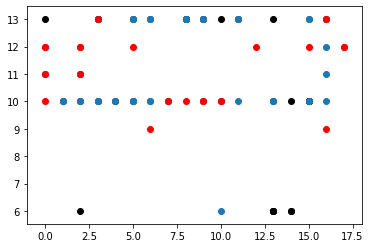

In [41]:
import numpy as np
import matplotlib.pyplot as plt
print(dronec)
x1 = [dronec[i][0] for i in range(len(dronec))]
y1 = [dronec[i][1] for i in range(len(dronec))]

x2 = [dronerc[i][0] for i in range(len(dronerc))]
y2 = [dronerc[i][1] for i in range(len(dronerc))]

x3 = [dronefc[i][0] for i in range(len(dronefc))]
y3 = [dronefc[i][1] for i in range(len(dronefc))]



plt.scatter(y3,x3,color='black')

plt.scatter(y1,x1)
plt.scatter(y2,x2,color='red')
plt.show

100%|██████████| 1000/1000 [00:03<00:00, 296.44it/s]


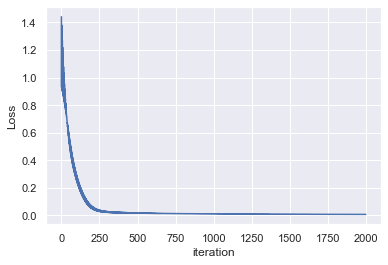

seq 0, prev = tensor([[ 4., 11.]])  -> predicted 5th step = tensor([[ 4.0181, 10.1336]]), actual step = tensor([[ 4., 10.]])
		predicted step 6 (prev = tensor([[[ 4., 10.]]])) = tensor([[3.8167, 8.9214]]), actual step = tensor([[4., 9.]])
		predicted step 7 (prev = tensor([[[4., 9.]]])) = tensor([[3.7085, 7.7733]]), actual step = tensor([[4., 8.]])
		predicted step 8 (prev = tensor([[[4., 8.]]])) = tensor([[3.6956, 6.6876]]), actual step = tensor([[4., 7.]])
		predicted step 9 (prev = tensor([[[4., 7.]]])) = tensor([[3.7559, 5.6683]]), actual step = tensor([[4., 6.]])
		predicted step 10 (prev = tensor([[[4., 6.]]])) = tensor([[3.8623, 4.7333]]), actual step = tensor([[4., 5.]])
		predicted step 11 (prev = tensor([[[4., 5.]]])) = tensor([[3.9918, 3.9030]]), actual step = tensor([[4., 4.]])
		predicted step 12 (prev = tensor([[[4., 4.]]])) = tensor([[4.1273, 3.1905]]), actual step = tensor([[4., 3.]])
		predicted step 13 (prev = tensor([[[4., 3.]]])) = tensor([[4.2568, 2.5978]]), actual

In [53]:
import seaborn as sns
from tqdm import trange
sns.set()

class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

s1 = torch.tensor([[4, 15], [4, 14], [4, 13], [4, 12], [4, 11], [4, 10], [4, 9], [4, 8], [4,7], [4, 6], [4, 5], [4, 4], [4, 3], [4, 2]], dtype=torch.float)[:, None, :] 
s2 = torch.tensor([[4, 15], [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11, 15],[12, 15],[12,14],[12,13],[12,12],[12,11],[12,10],[12,9],[12,8],[12,7],[12,6],[12,5]],dtype=torch.float)[:, None, :]

x = torch.cat((s1,s2),dim=0)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
    for s in sequences:
        pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
        err = criterion(pred, s[1:, ...])  # predict next step for each step
        opt.zero_grad()
        err.backward()
        opt.step()
        loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')